# Midiendo rendimiento y riesgo con datos históricos

<img style="float: right; margin: 0px 0px 15px 15px;" src="https://upload.wikimedia.org/wikipedia/commons/7/7d/Copper_Price_History_USD.png" width="600px" height="400px" />

> Ya sabemos que podemos caracterizar la distribución de rendimientos de un activo mediante una medida de tendencia central (media: rendimiento esperado) y una medida de dispersión (desviación estándar: volatilidad). 

> En la clase pasada vimos como obtener reportes históricos de precios de activos. ¿Cómo usamos estos históricos para medir el rendimiento esperado y la volatilidad de los rendimientos?

*Objetivos:*
- Calcular los rendimientos a partir de históricos de precios.
- Estimar rendimiento esperado y riesgo a partir de históricos de rendimientos.
- Anualizar rendimiento y volatilidad cuando los datos están en una base de tiempo menor.
- Verificar la relación entre rendimiento y riesgo a través de datos reales.

**Referencias:**
- http://pandas.pydata.org/
- https://pandas-datareader.readthedocs.io/en/latest/
- Notas del curso "Portfolio Selection and Risk Management", Rice University, disponible en Coursera.
___

## 1. Cálculo de los rendimientos

Muy bien, ya entonces sabemos descargar históricos de precios...

**Ejemplo:** trabajaremos esta clase con activos que se encuentran en el top-10 del índice S&P500. Descargar precios ajustados en el cierre de Microsoft (MSFT), Apple (AAPL), Amazon (AMZN), Facebook (FB) y Alphabet Inc. (GOOGL) desde el primero de enero del 2015 hasta hoy.

In [1]:
# Importar paquetes
import pandas_datareader.data as web
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
# Función para descargar precios de cierre ajustados:
def get_adj_closes(tickers, start_date=None, end_date=None):
    # Fecha inicio por defecto (start_date='2010-01-01') y fecha fin por defecto (end_date=today)
    # Descargamos DataFrame con todos los datos
    closes = web.DataReader(name=tickers, data_source='yahoo', start=start_date, end=end_date)
    # Solo necesitamos los precios ajustados en el cierre
    closes = closes['Adj Close']
    # Se ordenan los índices de manera ascendente
    closes.sort_index(inplace=True)
    return closes

In [3]:
# Información
tickers = ['MSFT', 'AAPL', 'AMZN', 'FB', 'GOOGL', '^GSPC']
start = '2015-01-01'

In [4]:
# Precios diarios ajustados en el cierre
closes = get_adj_closes(tickers=tickers,
                        start_date=start)
closes.head()

Symbols,MSFT,AAPL,AMZN,FB,GOOGL,^GSPC
Date,,,,,,
2015-01-02,41.539135,24.861401,308.519989,78.449997,529.549988,2058.199951
2015-01-05,41.157158,24.161013,302.190002,77.190002,519.460022,2020.579956
2015-01-06,40.553074,24.163294,295.290009,76.150002,506.640015,2002.609985
2015-01-07,41.068310,24.502111,298.420013,76.150002,505.149994,2025.900024
2015-01-08,42.276463,25.443539,300.459991,78.180000,506.910004,2062.139893


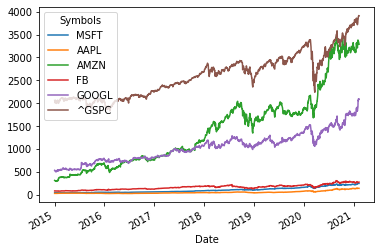

In [5]:
# Gráfico de histórico de precios diarios
closes.plot();

### 1.1. Rendimientos porcentuales

Muy bien, pero para el análisis no trabajamos con los precios sino con los rendimientos... **¿porqué?**

Para una sucesión de precios $\{S_t\}_{t=0}^{n}$, el rendimiento simple $R_t$ se define como el el cambio porcentual
$$
R_t=\frac{S_t-S_{t-1}}{S_{t-1}}
$$
para $t=1,\ldots,n$.

*¡Cuidado!* los rendimientos son de acuerdo a la base de tiempo en que se reportan los precios. Por ejemplo: 
- si los precios se reportan en una base diaria, los rendimientos también son diarios;
- si los precios se reportan en una base mensual, los rendimientos también son mensuales.

In [6]:
# S_{t-1}
r = (closes - closes.shift()) / closes.shift()
r.head()

Symbols,MSFT,AAPL,AMZN,FB,GOOGL,^GSPC
Date,,,,,,
2015-01-02,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,-0.009196,-0.028172,-0.020517,-0.016061,-0.019054,-0.018278
2015-01-06,-0.014677,0.000094,-0.022833,-0.013473,-0.024679,-0.008893
2015-01-07,0.012705,0.014022,0.010600,0.000000,-0.002941,0.011630
2015-01-08,0.029418,0.038422,0.006836,0.026658,0.003484,0.017888


In [7]:
help(closes.pct_change)

Help on method pct_change in module pandas.core.generic:

pct_change(periods=1, fill_method='pad', limit=None, freq=None, **kwargs) -> ~FrameOrSeries method of pandas.core.frame.DataFrame instance
    Percentage change between the current and a prior element.
    
    Computes the percentage change from the immediately previous row by
    default. This is useful in comparing the percentage of change in a time
    series of elements.
    
    Parameters
    ----------
    periods : int, default 1
        Periods to shift for forming percent change.
    fill_method : str, default 'pad'
        How to handle NAs before computing percent changes.
    limit : int, default None
        The number of consecutive NAs to fill before stopping.
    freq : DateOffset, timedelta, or str, optional
        Increment to use from time series API (e.g. 'M' or BDay()).
    **kwargs
        Additional keyword arguments are passed into
        `DataFrame.shift` or `Series.shift`.
    
    Returns
    -----

In [8]:
# Calcular rendimientos
ret = closes.pct_change().dropna()
ret.head()

Symbols,MSFT,AAPL,AMZN,FB,GOOGL,^GSPC
Date,,,,,,
2015-01-05,-0.009196,-0.028172,-0.020517,-0.016061,-0.019054,-0.018278
2015-01-06,-0.014677,0.000094,-0.022833,-0.013473,-0.024679,-0.008893
2015-01-07,0.012705,0.014022,0.010600,0.000000,-0.002941,0.011630
2015-01-08,0.029418,0.038422,0.006836,0.026658,0.003484,0.017888
2015-01-09,-0.008405,0.001072,-0.011749,-0.005628,-0.012211,-0.008404


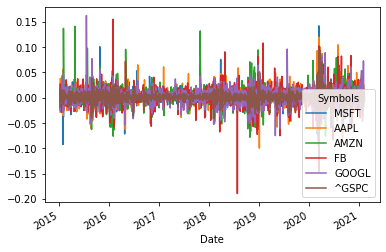

In [9]:
# Graficar...
ret.plot();

**¿Qué se observa respecto a los precios?**

Respuestas:
- Los rendimientos parecen conservar tendecias estadísticas constantes (por ejemplo, oscilan al rededor de números cercanos a cero). 

### 1.2. Rendimientos logarítmicos (log-rendimientos)

Otro rendimiento usado con frecuencia es el rendimiento continuamente compuesto o rendimiento logaritmico. Éste, está definido como

$$
r_t=\ln\left(\frac{S_t}{S_{t-1}}\right).
$$

Es fácil darse cuenta que $r_t=\ln(1+R_t)$.

<font color=blue>Ver en el tablero</font> que si $0\leq|x|\ll 1$, entonces $\ln(1+x)\approx x$.

In [10]:
# Calcular rendimientos continuamente compuestos
log_ret = np.log(closes / closes.shift()).dropna()
log_ret.head()

Symbols,MSFT,AAPL,AMZN,FB,GOOGL,^GSPC
Date,,,,,,
2015-01-05,-0.009238,-0.028576,-0.020731,-0.016191,-0.019238,-0.018447
2015-01-06,-0.014786,0.000094,-0.023098,-0.013565,-0.024989,-0.008933
2015-01-07,0.012625,0.013925,0.010544,0.000000,-0.002945,0.011563
2015-01-08,0.028994,0.037703,0.006813,0.026309,0.003478,0.017730
2015-01-09,-0.008441,0.001072,-0.011818,-0.005644,-0.012286,-0.008439


In [11]:
log_ret2 = np.log(ret + 1)

In [12]:
log_ret == log_ret2

Symbols,MSFT,AAPL,AMZN,FB,GOOGL,^GSPC
Date,,,,,,
2015-01-05,True,True,True,True,True,True
2015-01-06,True,True,True,True,True,True
2015-01-07,True,True,True,True,True,True
2015-01-08,True,True,True,True,True,True
2015-01-09,True,True,True,True,True,True
...,...,...,...,...,...,...
2021-02-04,True,True,True,True,True,True
2021-02-05,True,True,True,True,True,True
2021-02-08,True,True,True,True,True,True


In [13]:
# Recordar rendimientos porcentuales. Ver que son similares
ret.head()

Symbols,MSFT,AAPL,AMZN,FB,GOOGL,^GSPC
Date,,,,,,
2015-01-05,-0.009196,-0.028172,-0.020517,-0.016061,-0.019054,-0.018278
2015-01-06,-0.014677,0.000094,-0.022833,-0.013473,-0.024679,-0.008893
2015-01-07,0.012705,0.014022,0.010600,0.000000,-0.002941,0.011630
2015-01-08,0.029418,0.038422,0.006836,0.026658,0.003484,0.017888
2015-01-09,-0.008405,0.001072,-0.011749,-0.005628,-0.012211,-0.008404


In [14]:
# Veamos el valor absoluto de la diferencia
np.abs(ret - log_ret)

Symbols,MSFT,AAPL,AMZN,FB,GOOGL,^GSPC
Date,,,,,,
2015-01-05,4.254048e-05,4.044363e-04,0.000213,1.303776e-04,0.000184,1.691084e-04
2015-01-06,1.087802e-04,4.456921e-09,0.000265,9.158795e-05,0.000310,3.978297e-05
2015-01-07,8.003417e-05,9.739875e-05,0.000056,0.000000e+00,0.000004,6.710683e-05
2015-01-08,4.244096e-04,7.197575e-04,0.000023,3.491306e-04,0.000006,1.581125e-04
2015-01-09,3.552227e-05,5.746471e-07,0.000070,1.589726e-05,0.000075,3.551111e-05
...,...,...,...,...,...,...
2021-02-04,8.321742e-06,3.261411e-04,0.000015,1.801028e-07,0.000003,5.847459e-05
2021-02-05,3.080311e-07,4.808825e-06,0.000020,1.817706e-05,0.000145,7.575557e-06
2021-02-08,6.209268e-07,6.011321e-07,0.000038,1.613318e-05,0.000002,2.724088e-05


Por lo anterior, muchas veces se usan para el análisis los rendimientos continuamente compuestos.
___

## 2. Caracterización de la distribución de los rendimientos

Entonces:
- partimos de que tenemos los rendimientos porcentuales diarios de Apple, Walmart, IBM y Nike desde inicios del 2011 a finales del 2015;
- ¿cómo resumirían estos datos?

In [15]:
# Rendimiento medio diario (media aritmética)
ret.mean()

Symbols
MSFT     0.001303
AAPL     0.001278
AMZN     0.001728
FB       0.001012
GOOGL    0.001037
^GSPC    0.000487
dtype: float64

In [16]:
# Volatilidad diaria (desviación estándar)
ret.std()

Symbols
MSFT     0.017508
AAPL     0.018705
AMZN     0.019482
FB       0.020070
GOOGL    0.017031
^GSPC    0.011729
dtype: float64

In [17]:
# Podemos resumir en un DataFrame
summary = pd.DataFrame(data={'Media': ret.mean(),
                             'Vol': ret.std()})
summary

,Media,Vol
Symbols,,
MSFT,0.001303,0.017508
AAPL,0.001278,0.018705
AMZN,0.001728,0.019482
FB,0.001012,0.020070
GOOGL,0.001037,0.017031
^GSPC,0.000487,0.011729


Normalmente se reportan rendimientos esperados y volatilidades en una base anual. Para anualizar:

$$E[r_a]=12E[r_m]=252E[r_d]=52E[r_w],\text{ y}$$

$$\sigma_{r_a}=\sqrt{12}\sigma_{r_m}=\sqrt{252}\sigma_{r_d}=\sqrt{52}\sigma_{r_w}$$

In [18]:
# Resumen en base anual
annual_summary = pd.DataFrame(data={'Media': 252 * ret.mean(),
                                     'Vol': (252**0.5) * ret.std()})
annual_summary

,Media,Vol
Symbols,,
MSFT,0.328232,0.277929
AAPL,0.322146,0.296930
AMZN,0.435510,0.309268
FB,0.254906,0.318609
GOOGL,0.261272,0.270359
^GSPC,0.122659,0.186185


In [19]:
from matplotlib import pyplot as plt

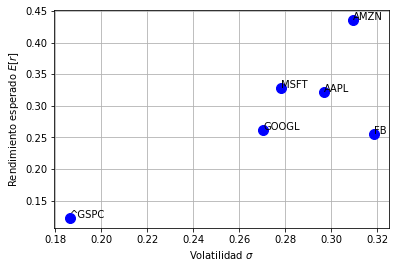

In [20]:
# Gráfico rendimiento esperado vs. volatilidad
plt.figure(figsize=(6, 4))
plt.plot(annual_summary['Vol'], annual_summary['Media'], 'bo', ms=10)
for i in range(len(annual_summary)):
    plt.text(annual_summary.iloc[i, 1], annual_summary.iloc[i, 0], annual_summary.index[i])
plt.xlabel('Volatilidad $\sigma$')
plt.ylabel('Rendimiento esperado $E[r]$')
plt.grid()

### 2.1 Ajuste de curvas con mínimos cuadrados
Consideramos que tenemos un conjunto de n pares ordenados de datos $(\sigma_{r_i},E[r_i])$, para $i=1,2,3,\dots,n$... **en este caso corresponden a volatilidad y rendimiento esperado**

#### ¿Cuál es la recta que mejor se ajusta a estos datos?
Consideramos entonces ajustes de la forma $\hat{f}(\sigma) = \beta_0+\beta_1 \sigma = \left[1 \quad \sigma\right]\left[\begin{array}{c} \beta_0 \\ \beta_1 \end{array}\right]=\left[1 \quad \sigma\right]\boldsymbol{\beta}$ (lineas rectas).

Para decir '*mejor*', tenemos que definir algún sentido en que una recta se ajuste *mejor* que otra.

**Mínimos cuadrados**: el objetivo es seleccionar los coeficientes $\boldsymbol{\beta}=\left[\beta_0 \quad \beta_1 \right]^T$, de forma que la función evaluada en los puntos $\sigma_{r_i}$ ($\hat{f}(\sigma_{r_i})$) aproxime los valores correspondientes $E[r_i]$.

La formulación por mínimos cuadrados, encuentra los $\boldsymbol{\beta}=\left[\beta_0 \quad \beta_1 \right]^T$ que minimiza
$$\sum_{i=1}^{n}(E[r_i]-\hat{f}(\sigma_{r_i}))^2$$

In [21]:
# Importar el módulo optimize de la librería scipy
from scipy import optimize as opt

In [22]:
# Funcion minimize
help(opt.minimize)

Help on function minimize in module scipy.optimize._minimize:

minimize(fun, x0, args=(), method=None, jac=None, hess=None, hessp=None, bounds=None, constraints=(), tol=None, callback=None, options=None)
    Minimization of scalar function of one or more variables.
    
    Parameters
    ----------
    fun : callable
        The objective function to be minimized.
    
            ``fun(x, *args) -> float``
    
        where x is an 1-D array with shape (n,) and `args`
        is a tuple of the fixed parameters needed to completely
        specify the function.
    x0 : ndarray, shape (n,)
        Initial guess. Array of real elements of size (n,),
        where 'n' is the number of independent variables.
    args : tuple, optional
        Extra arguments passed to the objective function and its
        derivatives (`fun`, `jac` and `hess` functions).
    method : str or callable, optional
        Type of solver.  Should be one of
    
            - 'Nelder-Mead' :ref:`(see here) <op

In [23]:
# Funcion objetivo y condicion inicial
def fun_obj(beta, E_r, s):
    recta = beta[0] + beta[1] * s
    return ((E_r - recta)**2).sum()

beta_ini = [0, 0]

In [24]:
# Resolver problema de optimizacion
min_sq = opt.minimize(fun=fun_obj,
                      x0=beta_ini,
                      args=(annual_summary['Media'], annual_summary['Vol']))

In [25]:
min_sq

      fun: 0.021214422020851054
 hess_inv: array([[  3.41984513, -12.06491107],
       [-12.06491107,  43.62702367]])
      jac: array([4.65661287e-10, 6.98491931e-10])
  message: 'Optimization terminated successfully.'
     nfev: 32
      nit: 5
     njev: 8
   status: 0
  success: True
        x: array([-0.17806085,  1.68331383])

In [26]:
beta = min_sq.x
beta

array([-0.17806085,  1.68331383])

$y = -0.1768 + 1.6796  x$

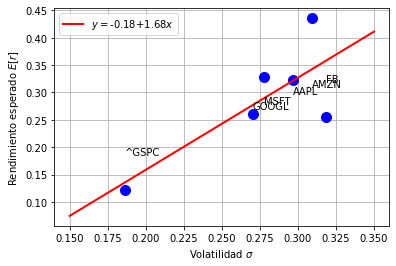

In [31]:
# Ventana para graficar
plt.figure(figsize=(6, 4))
plt.plot(annual_summary['Vol'], annual_summary['Media'], 'bo', ms=10)
s = np.linspace(0.15, 0.35)
plt.plot(s, beta[0] + beta[1] * s, 'r', lw=2, 
         label=f'$y=${np.round(beta[0], 2)}+{np.round(beta[1], 2)}$x$')
for i in range(len(annual_summary)):
    plt.text(annual_summary.iloc[i, 1], annual_summary.iloc[i, 1], annual_summary.index[i])
plt.xlabel('Volatilidad $\sigma$')
plt.ylabel('Rendimiento esperado $E[r]$')
plt.grid()
plt.legend(loc='best')

**¿Qué se puede concluir acerca de la relación entre riesgo (medido con la volatilidad) y el rendimiento esperado (medido con la media)?**

Respuestas:
- La pendiente de la recta es positiva, lo que confirma la relación positiva entre rendimiento esperado y riesgo.
- Si el mercado solo estuviera dado por los cinco activos analizados, la tasa libre de riesgo sería $-17.69\%$.
- Por cada unidad de riesgo (volatilidad), el rendimiento aumenta $168\%$.

## 3. Comentarios finales acerca del uso de datos históricos.

### ¡Cuidado!
- Es cierto que los patrones que vemos sobre periodos largos de tiempo en diferentes tipos de intrumentos son muy robustos en términos de la relación rendimiento/riesgo (positiva).
- Por tanto, esperamos rendimientos más altos en el futuro cuando asumimos cierto riesgo.
- ¿Cómo encontramos ese 'rendimiento esperado' en el futuro'? Datos históricos (humanos: tendencia a generalizar)

- Entonces, la idea es que si los rendimientos esperados son un p.e. estacionario, el promedio de muchos rendimientos pasados es una buena estimación del rendimiento esperado futuro (Teorema del límite central).
- ¿Deberíamos pensarlo dos veces?

## SI

Problemas:
- La muestra de datos en el periodo específico de tiempo puede estar sesgada.
- Ventanas de tiempo más grandes reducen especificidad de la muestra y estimados más precisos.
 - Aún así, datos muy viejos pueden ser no representativos.
- Nuevos fondos o estrategias de inversión están a menudo sesgados positivamente:
 - reporte de resultados en tiempos voluntarios;
 - las que mueren (no funcionan), no se reportan;

# Anuncios parroquiales:
## 1. Fin Módulo 1. Revisar que se hayan cumplido los objetivos del módulo (Clase0)
## 2. Tarea: revisar archivo "Tarea3_MidiendoRendimientoRiesgo" en clase. 
## 3. Recordar quiz la siguiente clase.

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Esteban Jiménez Rodríguez.
</footer>